In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology
import glass
import glass.ext.camb


In [2]:
nside=256
freqs=np.arange(544,1088,step=10) #instead of steps of1MHz use 10
nfreqs=len(freqs)
lmax=3*nside -1

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

In [3]:
z_f= (1420/544)-1
z_i= (1420/1087)-1

print(z_i, z_f)

0.30634774609015647 1.6102941176470589


In [4]:
def compute_matter_cls_corr(z_i:float, z_f: float, nfreq: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB with correlations between shells.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreq)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)
    
    # compute angular matter power spectra with CAMB
    cls = glass.ext.camb.matter_cls(pars, lmax, shells)
    
    return shells, cls

In [5]:
shells_i, cls_hi=compute_matter_cls_corr(z_i,z_f, nfreqs, lmax)
print(len(cls_hi))

/tmp/ipykernel_2736153/1021660912.py:17: UserWarning: first triangular window does not start at z=0
  shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)


1485


In [6]:
cls_healpix=glass.glass_to_healpix_spectra(cls_hi)

In [7]:
idx= glass.spectra_indices(len(shells_i))
x,y=idx[5]
print(x)
print(y)
print(len(idx))

2
0
1485


In [8]:
# Initialize the array to store the full spectra
cls_full = np.zeros((nfreqs, nfreqs, lmax + 1))

# Loop over index pairs (i, j)
for pair in idx:
    i, j = pair  # unpack the pair
    cl_ij = glass.getcl(cls_healpix, i, j)  # get the C_l^{ij} spectrum
    cls_full[i, j, :] = cl_ij
    if i != j:
        cls_full[j, i, :] = cl_ij  # fill the symmetric entry

print(cls_full.shape) #C_l{ij} in GLASS ordering

(55, 55, 768)


In [29]:
hi_corr_maps=np.zeros((nfreqs, hp.nside2npix(nside)))
for i in range(nfreqs):
    hi_corr_maps[i,:]= hp.synfast(cls_full[i,i,:], nside)

In [38]:
np.save('hi_corr_maps',hi_corr_maps)

In [9]:
ells=np.arange(0, lmax+1)

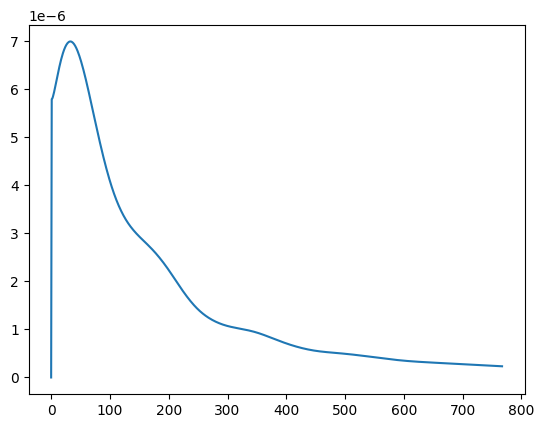

In [10]:
plt.plot(ells,cls_full[13, 13, :])

In [11]:
cov=glass.cov_from_spectra(cls_hi,lmax=lmax)

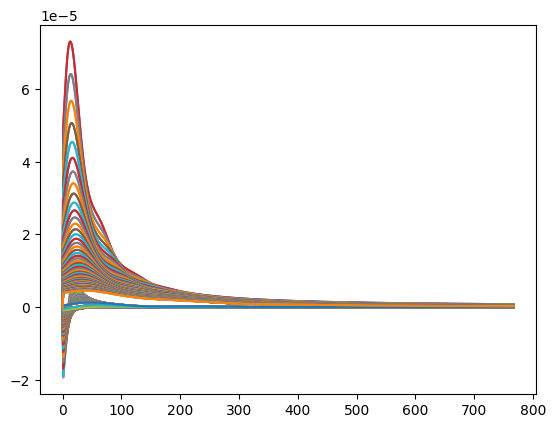

In [12]:
for i in range(nfreqs-1):
    for j in range(nfreqs-1):
        if i != j:
            plt.plot(ells, cov[:, i, j], label=f"{freqs[i]}-{freqs[j]} MHz")
# plt.legend()

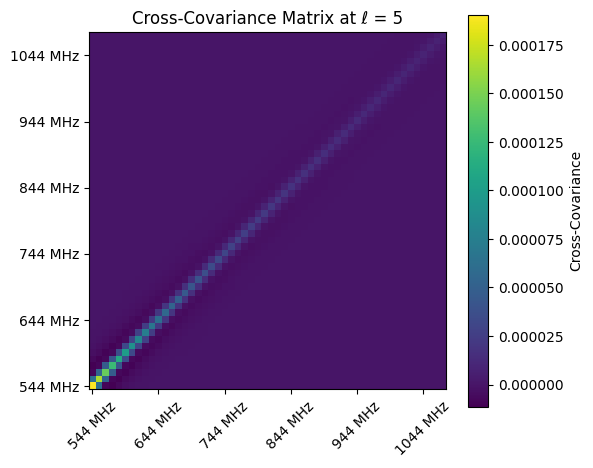

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example ℓ index to visualize
ell_index = np.where(ells == 5)[0][0]  # Or choose manually

# Extract 2D cross-covariance matrix at that ℓ
cov_matrix = cov[ell_index, :, :]

plt.figure(figsize=(6, 5))
im = plt.imshow(cov_matrix, origin='lower', cmap='viridis')
plt.colorbar(im, label='Cross-Covariance')

# Prepare spaced tick positions (every 10 frequencies)
step = 10
xticks = np.arange(0, nfreqs - 1, step)
yticks = xticks

# Labels for spaced ticks
xtick_labels = [f"{freqs[i]} MHz" for i in xticks]
ytick_labels = xtick_labels.copy()

plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
plt.yticks(ticks=yticks, labels=ytick_labels)

plt.title(f"Cross-Covariance Matrix at ℓ = {ells[ell_index]}")
plt.tight_layout()
plt.show()


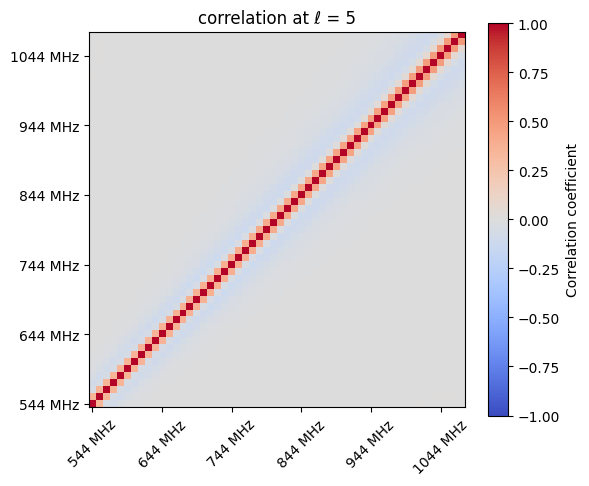

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Choose ℓ index to visualize
ell_index = np.where(ells == 5)[0][0]  # Or set manually

# Extract covariance matrix at ℓ
cov_matrix = cov[ell_index, :, :]

# Compute correlation matrix
diag = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / diag[:, None] / diag[None, :]

plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix, origin='lower', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation coefficient')

# Ticks every 10 frequencies to reduce clutter
step = 10
xticks = np.arange(0, nfreqs - 1, step)
yticks = xticks
xtick_labels = [f"{freqs[i]} MHz" for i in xticks]
ytick_labels = xtick_labels.copy()

plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
plt.yticks(ticks=yticks, labels=ytick_labels)

plt.title(f"correlation at ℓ = {ells[ell_index]}")
plt.tight_layout()
plt.show()


In [23]:
d1=np.diag(corr_matrix, k=1)
d_m1=np.diag(corr_matrix, k=-1)
# Create a matrix of zeros
sparse_corr = np.zeros_like(corr_matrix)

# Fill in the three diagonals
np.fill_diagonal(sparse_corr, np.diag(corr_matrix))
np.fill_diagonal(sparse_corr[1:], np.diag(corr_matrix, k=1))
np.fill_diagonal(sparse_corr[:,1:], np.diag(corr_matrix, k=-1))
print(sparse_corr)

[[1.         0.34909367 0.         ... 0.         0.         0.        ]
 [0.34909367 1.         0.34875369 ... 0.         0.         0.        ]
 [0.         0.34875369 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.48944879 0.        ]
 [0.         0.         0.         ... 0.48944879 1.         0.49258575]
 [0.         0.         0.         ... 0.         0.49258575 1.        ]]


In [24]:
np.save('sparse_hi_corr', sparse_corr)